# Fruit Recognition

### Import Package-package yang dibutuhkan

Sebelum melakukan pengenalan, berikut ini adalah package-package yang harus di import terlebih dahulu

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog

import glob

### Deskripsi Descriptor
Descriptor yang digunakan ada dua, yaitu descriptor bentuk dan descriptor warna. Kedua descriptor tersebut adalah sebagai berikut

1. HOG (Histogram of Oriented Gradient)

    Ekstraksi ciri HOG (Histogram of Oriented Gradient) pertama kali diperkenalkan oleh Navneed Dalal dan Bill Triggs untuk berbagai objek penelitian, terutama deteksi pejalan kaki. Ekstrasi ciri ini sangat menguntungkan karena ekstraksi ciri tersebut menunjukkan tampilan dan bentuk dari objek yang dapat digambarkan menggunakan magnitude dan orientasi. Skimage juga telah menyediakan library HOG itu sendiri

In [2]:
def FtrExtractHOG(img):
    #Preprocessing using grayscale and resize
    #img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img=resize(img, (72, 72),anti_aliasing=True)
    #Feature Extraction using HOG
    ftr,_=hog(img, orientations=8, pixels_per_cell=(16, 16),
            cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr

2. Color Histogram

    Color histogram merupakan metode ekstraksi ciri warna yang sering dan mudah digunakan dalam mengekstrak ciri warna. Color histogram mendefinisikan jumlah pixel yang muncul pada gambar. Untuk mendapatkan color histogram, agar akurasi pengenalan baik dilakukan pengubahan channel dari RGB ke HSV. Kemudian, buat histogram dari masing-masing channel warna. Setelah itu barulah concat histogram tersebut

In [3]:
def FtrExtractColorHist(img):
    chans = cv2.split(img)
    colors = ("h", "s", "v")
    features = []

    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)
    return np.array(features).flatten()

### Deskripsi Dataset

Sebelum melakukan image recognition, kita akan melakukan load dataset. Dataset yang digunakan adalah dataset altenatif dari assignment 3, yaitu dataset buah-buahan. Dataset tersebut terdiri dari 7 kelas, yaitu apple, banana, lemon, lime, orange, pear, peach. Jumlah dataset tersebut diantaranya adalah sebagai berikut

In [4]:
def loadimage(arr,n,name_of_fruit):
    label=[]
    for i in range(n):
        strr = "rgb/"+name_of_fruit+"_"+str(i+1)+"/*.png"
        #print(strr)
        for file in glob.glob(strr):
            img=np.asarray(plt.imread(file))
            arr.append(img)
            label.append(name_of_fruit)
    return arr,label

apple=[]
banana =[]
lemon=[]
lime=[]
orange=[]
peach=[]
pear=[]

apple,label_apple=loadimage(apple,5,"apple")
banana,label_banana=loadimage(banana,4,"banana")
lemon,label_lemon=loadimage(lemon,6,"lemon")
lime,label_lime=loadimage(lime,4,"lime")
orange,label_orange=loadimage(orange,4,"orange")
peach,label_peach=loadimage(peach,3,"peach")
pear,label_pear=loadimage(pear,3,"pear")

raw_atribut = {'Kelas': ['Apple','Banana','Lemon','Lime','Orange', 'Pear', 'Peach'],
           'Jumlah': [np.shape(apple)[0],np.shape(banana)[0],np.shape(lemon)[0],np.shape(lime)[0],np.shape(orange)[0],np.shape(peach)[0],np.shape(pear)[0]]}
atribut= pd.DataFrame(raw_atribut,
                       columns=['Kelas','Jumlah'])
atribut

,Kelas,Jumlah
0,Apple,3098
1,Banana,2826
2,Lemon,3747
3,Lime,2514
4,Orange,2834
5,Pear,2082
6,Peach,2026


Total dari dataset tersebut adalah 19.127 gambar. Berikut ini adalah contoh gambar dari dataset tersebut.

Contoh Dataset


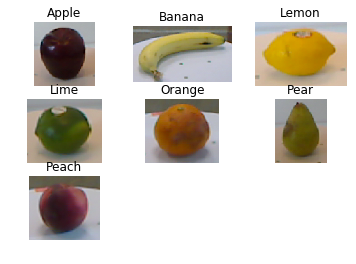

In [5]:
print('Contoh Dataset')
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.set_title('Apple')
ax1.set_axis_off()
ax1.imshow(apple[0])

ax2 = fig.add_subplot(3,3,2)
ax2.set_title('Banana')
ax2.set_axis_off()
ax2.imshow(banana[0])

ax3 = fig.add_subplot(3,3,3)
ax3.set_title('Lemon')
ax3.set_axis_off()
ax3.imshow(lemon[0])

ax4 = fig.add_subplot(3,3,4)
ax4.set_title('Lime')
ax4.set_axis_off()
ax4.imshow(lime[0])

ax5 = fig.add_subplot(3,3,5)
ax5.set_title('Orange')
ax5.set_axis_off()
ax5.imshow(orange[0])

ax6 = fig.add_subplot(3,3,6)
ax6.set_title('Pear')
ax6.set_axis_off()
ax6.imshow(pear[0])

ax7 = fig.add_subplot(3,3,7)
ax7.set_title('Peach')
ax7.set_axis_off()
ax7.imshow(peach[0])

### Deskripsi Algoritma Machine Learning
Algoritma machine learning yang digunakan pada sistem ini adalah algoritma k-NN (k-Nearest Neighbor). Algoritma tersebut termasuk algoritma machine learning instance based. Algoritma tersebut mengklasifikasikan objek berdasarkan jarak kemiripannya. Untuk mengetahui kelas data tersebut, pertama-tama adalah menentukan nilai k, yaitu jumlah objek yang akan dipilih. Kemudian mengkalkulasikan jarak antara objek tersebut dengan objek yang lainnya. Setelah itu, ambil k objek berdasarkan jarak terdekat dari objek tersebut. Kemudian tentukan kelas dari objek tersebut dengan cara melihat objek yang paling banyak dari k objek tersebut. 

### Deskripsi Sistem yang Dibangun
Berikut ini merupakan block diagram untuk sistem yang dibangun.

<img src='Block_Diagram_Sisrek.png' width=120px>

Pertama-tama, lakukan input gambar terlebih dahulu. Kemudian lakukanlah preprocessing, yaitu memperbaiki gambar terlebih dahulu sebelum melakukan ekstraksi ciri. Kemudian melakukan ekstraksi ciri. Setelah melakukan ekstraksi ciri, selanjutnya adalah membagi dataset menjadi dua bagian, yaitu data training sebesar 67% dan data testing sebesar 33%. Namun, sebelum dilakukan split training dan testing, yang harus dilakukan adalah merandom terlebih dahulu urutan data tersebut agar proses learning menjadi lebih merata. Setelah itu lakukan klasifikasi pada data training. Setelah melakukan klasifikasi, lakukanlah pengujian dengan data testing.

### Implementasi
Berikut ini adalah implementasi dari sistem tersebut. Skenario implementasi dari sistem tersebut akan dibagi 2, yaitu implementasi pada deskriptor bentuk bentuk dan implementasi pada deskriptor warna.

#### Deskriptor Bentuk
Langkah pertama adalah melakukan preprocessing gambar. Preprocessing gambar yang dilakukan adalah melakukan grayscale dan resize, sehingga citra tersebut berukuran 72 x 72 dan bersifat keabuan.

In [6]:
def preprocessing1(arr):
    arr_prep=[]
    for i in range(np.shape(arr)[0]):
        img=cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img=resize(img, (72, 72),anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

Setelah itu langkah selanjutnya adalah melakukan ekstraksi ciri. Ekstraksi ciri yang dilakukan adalah HOG.

In [7]:
def featureExtraction1(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(FtrExtractHOG(arr[i]))
    return arr_feature

Kemudian lakukan concat pada semua data dari masing-masing kelas, baik data gambar maupun label

In [8]:
#Save DataTrain and the label
X_Shapedes =np.concatenate((apple,banana,lemon,lime,orange,peach,pear))
y_Shapedes =np.concatenate((label_apple,label_banana,label_lemon,label_lime,label_orange,label_peach,label_pear))

Setelah itu, lakukan split data train dan data test. Namun sebelum melakukan split data, data tersebut harus dirandom terlebih dahulu agar pembelajaran lebih merata.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_Shapedes, y_Shapedes, test_size=0.33, random_state=42)

Berikut ini adalah jumlah data train dan data test yang akan digunakan dalam sistem ini

In [10]:
print('Jumlah Data Train :',X_train.shape[0])
print('Jumlah Data Test  :',X_test.shape[0])

Jumlah Data Train : 12815
Jumlah Data Test  : 6312


Program utama dalam preprocessing dan ekstraksi ciri

In [11]:
#Preprocessing
X_trainp=preprocessing1(X_train)
X_testp=preprocessing1(X_test)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
#Feature Extraction
X_trainftr=featureExtraction1(X_trainp)
X_testftr=featureExtraction1(X_testp)

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Kemudian, lakukan klasifikasi k-NN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
knn_clf.fit(X_trainftr, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='distance')

Kemudian, lakukan pengujian dengan data test

In [14]:
y_knn_pred = knn_clf.predict(X_testftr)

Hitunglah akurasi pengujian tersebut. Metric akurasi yang digunakan adalah menghitung skor akurasi, yaitu menghitung berapa banyak jumlah objek yang benar dikenali dibagi dengan jumlah seluruh objek dikalikan dengan 100%

In [15]:
print(accuracy_score(y_test, y_knn_pred)*100,'%')

99.95247148288973 %


Contoh Hasil Pengenalan

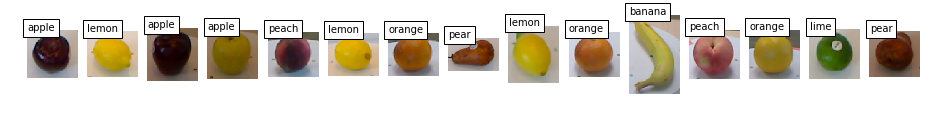

In [16]:
slice = 15

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test[i], interpolation='nearest')
    plt.text(0, 0, y_knn_pred[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

#### Deskriptor Warna
Langkah pertama adalah melakukan preprocessing gambar. Preprocessing gambar yang dilakukan adalah mengubah gambar dari RGB menjadi HSV, agar mendapatkan hasil pengenalan yang baik.

In [17]:
def preprocessing2(arr):
    arr_prep=[]
    for i in range(np.shape(arr)[0]):
        img=matplotlib.colors.rgb_to_hsv(arr[i])
        arr_prep.append(img)
    return arr_prep

Setelah itu langkah selanjutnya adalah melakukan ekstraksi ciri. Ekstraksi ciri yang dilakukan adalah Color Histogram.

In [18]:
def featureExtraction2(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(FtrExtractColorHist(arr[i]))
    return arr_feature

Kemudian lakukan concat pada semua data dari masing-masing kelas, baik data gambar maupun label

In [19]:
#Save DataTrain and the label
X_Colordes =np.concatenate((apple,banana,lemon,lime,orange,peach,pear))
y_Colordes =np.concatenate((label_apple,label_banana,label_lemon,label_lime,label_orange,label_peach,label_pear))

Setelah itu, lakukan split data train dan data test. Namun sebelum melakukan split data, data tersebut harus dirandom terlebih dahulu agar pembelajaran lebih merata.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_Colordes, y_Colordes, test_size=0.33, random_state=42)

Berikut ini adalah jumlah data train dan data test yang akan digunakan dalam sistem ini

In [21]:
print('Jumlah Data Train : ',X_train.shape[0])
print('Jumlah Data Test  :',X_test.shape[0])

Jumlah Data Train :  12815
Jumlah Data Test  : 6312


Program utama dalam preprocessing dan ekstraksi ciri

In [22]:
#Preprocessing
X_trainp=preprocessing2(X_train)
X_testp=preprocessing2(X_test)

In [23]:
#Feature Extraction
X_trainftr=featureExtraction2(X_trainp)
X_testftr=featureExtraction2(X_testp)

Kemudian, lakukan klasifikasi k-NN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=11)
knn_clf.fit(X_trainftr, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='distance')

In [25]:
y_knn_pred = knn_clf.predict(X_testftr)

Hitunglah akurasi pengujian tersebut

In [26]:
print(accuracy_score(y_test, y_knn_pred)*100,'%')

89.78136882129277 %


Contoh Hasil Pengenalan

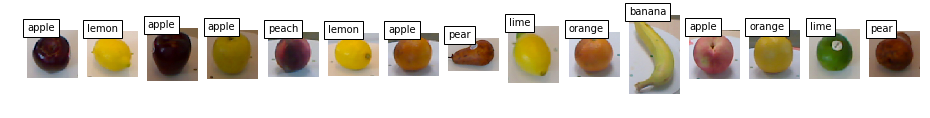

In [27]:
slice = 15

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1,slice , i+1)
    plt.imshow(X_test[i], interpolation='nearest')
    plt.text(0, 0, (y_knn_pred[i]), color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

### Analisis Akurasi
Setelah dilakukan implementasi diatas, pengenalan buah berdasarkan deskriptor bentuk memiliki akurasi sebesar 99.9%. Sedangkan pengenalan buah berdasarkan deskriptor warna memiliki akurasi sebesar 89.7%. Berdasarkan hasil akurasi tersebut, dapat disimpulkan bahwa pengenalan buah dengan deskriptor bentuk lebih baik daripada pengenalan buah berdasarkan deskriptor warna karena pada deskriptor warna, ada beberapa warna buah yang mirip seperti pada apel dan peach.

Nadya Aditama
1301154556
ICM 39 GAB